# Pyro AR2 Example

In [18]:
!pip install numpyro==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 5.0 MB/s 


In [126]:
import argparse
import os
import time

import jax
from jax import random
import jax.numpy as jnp

import numpy as np
import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from pyro.ops.stats import quantile


import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numpyro.set_platform("cpu")
numpyro.set_host_device_count("4")
# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Data

In [46]:
def get_weather_data(df):
  dfW = df[['temp', 'temp','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','snow_3h']].copy()

  # Set outliers to mean
  #dfW["pressure"] = dfW["pressure"].apply(lambda p: dfW["pressure"].mean() if )
  dfW.loc[(df["pressure"] > 1e4) | (df["pressure"] < 1e2), "pressure"] = df["pressure"].mean()

  # Normalize stuff
  dfW['temp'] = (dfW['temp'] - 273.15) / 50
  dfW['temp_min'] = (dfW['temp_min'] - 273.15) / 50
  dfW['temp_max'] = (dfW['temp_max'] - 273.15) / 50
  dfW['pressure'] = (dfW["pressure"] - 1013) / 1e3
  dfW['humidity'] = dfW["humidity"] / 100
  dfW['wind_speed'] = dfW["wind_speed"] / 50
  dfW['wind_deg'] = dfW["wind_deg"] / 360
  dfW['rain_1h'] = dfW["rain_1h"] / 1e3
  dfW['rain_3h'] = dfW["rain_3h"] / 1e3
  dfW['snow_3h'] = dfW["snow_3h"] / 1e3


  return dfW

def get_energy_data(df):
  dfE = df[[
    'generation biomass',
    'generation fossil',
    'generation hydro',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation solar',
    'generation total',
    'generation waste',
    'generation wind onshore'
  ]].copy()

  return dfE

In [47]:
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing

# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)


# start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

# convert to torch tensors
# X_W = torch.from_numpy(dfW.values).float()
# X_E = torch.from_numpy(dfE.values).float()
# obs = torch.from_numpy(df["price actual"].values).float()

# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfW.columns) + list(dfE.columns) + ["price_actual"], index = df.index)
# print(df_standardized.columns)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting



# covariates[:T1].mean(axis = 0), covariates.std(axis = 0)

Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

In [171]:
def model(y, T):
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, t):
        y_prev, y_prev_prev = carry
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, y_t

    timesteps = jnp.arange(2, y.shape[0] + T) #TODO Fix + T not working 
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        _, ys = scan(transition, init, timesteps)
    
    y_collection = jnp.concatenate((jnp.array([init[0], init[1]]), ys), axis=0)

    numpyro.sample(name='y_obs', fn=dist.Normal(loc=y_collection[:y.shape[0]], scale=sigma), obs=y[:y.shape[0]])
    numpyro.sample(name='y_pred', fn=dist.Normal(loc=y_collection[y.shape[0]:], scale=sigma), obs=None)

    return y_collection

In [63]:
def model2(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    """
    # Your code here
    beta1 = numpyro.sample(name='beta_1', fn=dist.Normal(loc=0., scale=5.))
    beta2 = numpyro.sample(name='beta_2', fn=dist.Normal(loc=0., scale=5.))
    tau = numpyro.sample(name='tau', fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample('noises', fn=dist.Normal(0.,1.), sample_shape=(T+T_forecast-2, ))
    sigma = numpyro.sample('sigma', fn=dist.HalfCauchy(scale=3.))
    z_prev1 = numpyro.sample(name='z_1', fn=dist.Normal(loc=0., scale=3.))
    z_prev2 = numpyro.sample(name='z_2', fn=dist.Normal(loc=0., scale=3.))


    def transition(carry, noise_t):
      beta1, beta2, z_prev1, z_prev2, tau = carry
      z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
      z_prev1 = z_prev2
      z_prev2 = z_t
      return (beta1, beta2, z_prev1, z_prev2, tau), z_t

    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    carry_updated, zs_exp = jax.lax.scan(f=transition, init=carry, xs=noises, length=T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    """
    # Your code here
    numpyro.sample(name='y_obs', fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name='y_pred', fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=None)
    return z_collection

## Inference

In [ ]:
start = time.time()
sampler = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(
    sampler,
    num_warmup=1000,
    num_samples=5000,
    num_chains=4,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

y_train = y[:T1]
mcmc.run(jax.random.PRNGKey(0), y=jnp.array(y_train), T=T2-T1)
mcmc.print_summary()
print("\nMCMC elapsed time:", time.time() - start)

posterior_samples = mcmc.get_samples()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  
sample:  51%|█████     | 3033/6000 [00:04<00:04, 737.94it/s, 7 steps of size 5.23e-01. acc. prob=0.91]

## Prediction Confidence Interval

In [127]:
hmc_samples = {k: v for k, v in posterior_samples.items()}
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

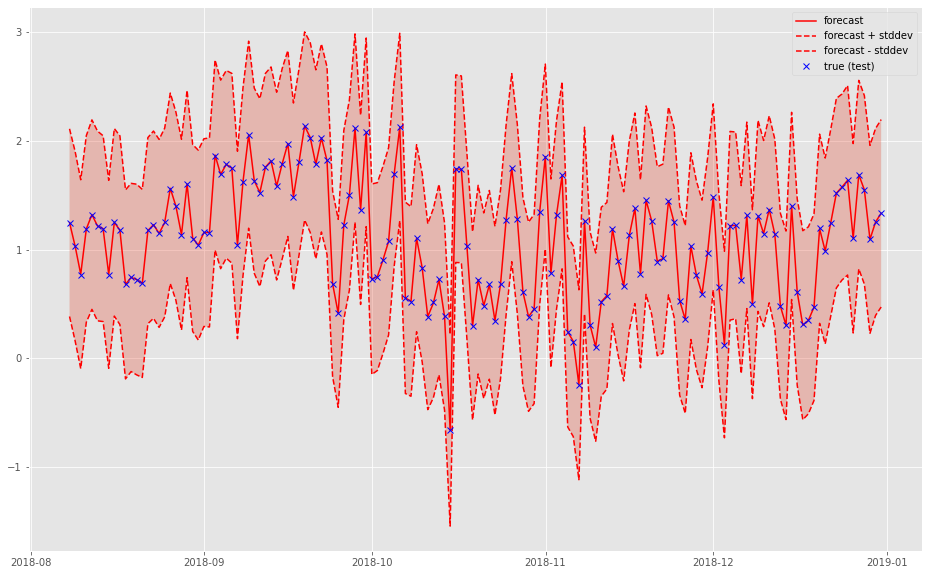

In [132]:
plt.plot(dates[T1:], y_pred_mean, "r-")
plt.plot(dates[T1:], y_pred_025, "r--")
plt.plot(dates[T1:], y_pred_975, "r--")
# plt.plot(dates[:T1], y[:T1], "b-")
plt.plot(dates[T1:], y[T1:], "bx")
plt.fill_between(dates[T1:], y_pred_025, y_pred_975, alpha=0.3)
plt.legend(["forecast","forecast + stddev","forecast - stddev", "true (test)"])
# plt.legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])
plt.show()

ValueError: ignored

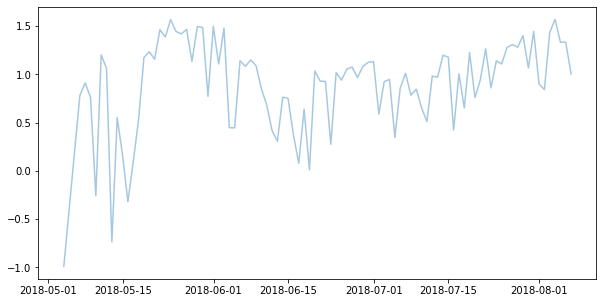

In [124]:
# pred = torch.tensor(hmc_samples["y_pred"].tolist()).squeeze().T
hmc_samples = {k: v for k, v in posterior_samples.items()}
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

T_START = T1 - 96
T_END = T1 + 48
ax.plot(dates[T_START:T1], y[T_START:T1], label="observed", alpha= .4)
# pred_p10, pred_p50, pred_p90 = quantile(pred, (0.25, 0.5, 0.75)).squeeze(-1)

# ax.plot(dates[T_START:T1], pred_p50[T_START:T1], label="train prediction", alpha = .4)
# ax.plot(dates[T_START:T1], y_pred_mean[T_START:T1], label="train prediction", alpha = .4)

ax.fill_between(dates[T1:T_END], y_pred_025[T1:T_END], y_pred_975[T1:T_END], alpha = .2)
ax.plot(dates[T1:T_END], y[T1:T_END], label="observed", alpha= .4)
ax.plot(dates[T1:T_END], y_pred_mean[T1:T_END], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

resid = obs - pred
print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs test residual: ", resid[:, T1:].abs().mean())